In [1]:
import pescador
import numpy as np
import keras
import pandas as pd
import torch
import os
import math
from kymatio.torch import Scattering1D
import sys
sys.path.append("../src")
import cnn
import ftm_ver2 as ftm2
import hcqt
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import random

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU,AveragePooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
import IPython.display as ipd
import librosa

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

2022-04-25 09:17:09.568232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:17:09.575341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:17:09.575950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## streamers

In [3]:
@pescador.streamable
def feature_sampler(ids,fold,params_normalized,idx,audio_path,J,Q,ftype):
    """
    output a {input, ground truth} pair for the designated audio sample
    """
    i = idx
    y = params_normalized[i,:] #ground truth
    fullpath = os.path.join(audio_path,fold,str(ids[i])+"_sound.wav") 
    x,sr = sf.read(fullpath)
    fmin = 0.4*sr*2**(-J)
    if ftype == "cqt":
        Sy = make_cqt(x,b=Q,sr=sr,n_oct=J,fmin=fmin)
        nfreq,ntime = Sy.shape
        Sy = Sy[:,:,None]
    elif ftype == "vqt":
        Sy = make_vqt(x,b=Q,sr=sr,n_oct=J,fmin=fmin)
        nfreq,ntime = Sy.shape
        Sy = Sy[:,:,None]
    elif ftype == "hcqt":
        Sy = make_hcqt(x,b=Q,sr=sr,n_oct=J-2,fmin=fmin)
        nharm,nfreq,ntime = Sy.shape
        Sy = Sy.reshape((nfreq,ntime,nharm))
    
    while True:
        yield {'input': Sy,'y': y}

        
def data_generator(ids,fold,params_normalized,feature_type,audio_path, batch_size, idx, active_streamers,
                        rate, random_state=12345678):
    """
    use streamers to output a batch of {input groundtruth} pairs. 
    """
    ftype = feature_type["type"]
    J = feature_type["J"]
    Q = feature_type["Q"]
    streams = [feature_sampler(ids,fold,params_normalized,i,audio_path,J,Q,ftype) for i in idx]
    #for i in idx: #how many streamers to open?
    #    streamer = pescador.Streamer(feature_sampler, df, params_normalized,i,audio_path,J,Q,ftype)
    #    streams.append(streamer)

    # Randomly shuffle the seeds
    random.shuffle(streams)

    mux = pescador.StochasticMux(streams, active_streamers, rate=rate, random_state=random_state)

    return pescador.maps.buffer_stream(mux, batch_size)


In [4]:
audio_path = "/home/han/data/drum_data/"
random_state=44000
def load_gt(fold):
	df = pd.read_csv(os.path.join(audio_path,"annotations", fold+"_param_v2.csv"))
	y = df.values[:, 1:-1]
	ids = df.values[:, 0]
	return y,ids

def preprocess_gt(y_train, y_val, y_test):
	#logscale
	for idx in [0,2,3]:
		y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]] #extract their log base values
		y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]] 
		y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]
	#normalize
	scaler = MinMaxScaler()
	scaler.fit(y_train)
	y_train_normalized = scaler.transform(y_train)
	y_val_normalized = scaler.transform(y_val)
	y_test_normalized = scaler.transform(y_test)

	return y_train_normalized,y_val_normalized,y_test_normalized

#Make CQT
def make_cqt(waveform,b,sr,n_oct,fmin):
	Cx = librosa.cqt(waveform,sr=sr,n_bins=(n_oct)*b,fmin=fmin,hop_length=256,bins_per_octave=b) 
	return Cx

#Make HCQT
def make_hcqt(waveform,b,sr,n_oct,fmin):
	comp_hcqt = hcqt.HCQT(sr,bins_per_octave=b,harmonics=[0.5,1,2,3,4,5],
                 n_octaves=n_oct-2,f_min=fmin,hop_length=256) #choice of hop size?
	h_cqt = comp_hcqt.compute_hcqt(waveform,sr)

	return h_cqt

#Make VQT
def make_vqt(waveform,b,sr,n_oct,fmin):
	Vx = librosa.vqt(waveform,sr=sr,n_bins=(n_oct)*b,fmin=fmin,hop_length=256,bins_per_octave=b) 
	return Vx

In [5]:
y_train,train_ids = load_gt("train")
y_test,test_ids = load_gt("test")
y_val,val_ids = load_gt("val")
#log scale w, p and D, normalize
y_train_normalized,y_val_normalized,y_test_normalized = preprocess_gt(y_train,y_val,y_test)


In [6]:
ftype="cqt"
J = 12
Q = 16
train_idx = np.arange(0,y_train.shape[0],1) #how long should this be?? #streamers to open
train_batches = data_generator(train_ids,
                               "train",
                            y_train_normalized, 
                            {"type":"cqt","J":12,"Q":16},
                            audio_path,
                            batch_size=64, 
                            idx=train_idx,
                            active_streamers=64,
                            rate=64,
                            random_state=random_state)

test_idx = np.arange(0,y_test.shape[0],1) #how long should this be?? #streamers to open
test_batches = data_generator(test_ids,
                               "test",
                            y_test_normalized, 
                            {"type":"cqt","J":12,"Q":16},
                            audio_path,
                            batch_size=64, 
                            idx=test_idx,
                            active_streamers=64,
                            rate=64,
                            random_state=random_state)
val_idx = np.arange(0,y_val.shape[0],1) #how long should this be?? #streamers to open
val_batches = data_generator(val_ids,
                             "val",
                            y_val_normalized, 
                            {"type":"cqt","J":12,"Q":16},
                            audio_path,
                            batch_size=64, 
                            idx=val_idx,
                            active_streamers=64,
                            rate=64,
                            random_state=random_state)

In [7]:
import cnn
example_str = feature_sampler(train_ids,"train",y_train_normalized,0,audio_path,J,Q,ftype)
for samp in example_str.iterate():
    ex_input = samp["input"]
    break
model = cnn.create_model_conv2d(n_oct=J,bins_per_oct=Q,S=ex_input[None,:])


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=256
  return f(*args, **kwargs)
2022-04-25 09:17:14.256104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:17:14.256736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:17:14.257282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA nod

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 257, 1)]     0         
                                                                 
 batch_normalization (BatchN  (None, 192, 257, 1)      4         
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 192, 32, 1)       0         
 ooling2D)                                                       
                                                                 
 conv1 (Conv2D)              (None, 192, 32, 128)      16512     
                                                                 
 average_pooling2d_1 (Averag  (None, 192, 8, 128)      0         
 ePooling2D)                                                     
                                                             

In [91]:
import datetime

batch_size=32
n_epoch=30
steps_per_epoch=2

In [ ]:
try:
    hist = model.fit(
        pescador.tuples(train_batches,'input','y'),
        steps_per_epoch=steps_per_epoch,
        epochs=n_epoch,
        verbose=1,
        validation_data=pescador.tuples(val_batches,'input','y'))
except KeyboardInterrupt:
    print("Stopping early")
finally:
    print("Finished: {}".format(datetime.datetime.now()))
    scores = model.evaluate_generator(pescador.tuples(val_batches,'input','y'))
    for val, name in zip(scores, model.metrics_names):
        print('Test {}: {:0.4f}'.format(name, val))

In [ ]:
model.fit(
        pescador.tuples(train_batches,'input','y'),
        steps_per_epoch=10,
        epochs=1,
        verbose=1,
        validation_data=pescador.tuples(val_batches,'input','y'),
        validation_steps=100)

## load checkpoint model

In [22]:
import cnn

In [8]:
example_str = feature_sampler(train_ids,"train",y_train_normalized,0,audio_path,J,Q,ftype)
for samp in example_str.iterate():
    ex_input = samp["input"]
    break
sr = 22050
freqs = librosa.cqt_frequencies(n_bins=J*Q,fmin=0.4*sr*2**(-J),bins_per_octave=Q)
model = cnn.create_model_conv2d_onetask(n_oct=J,bins_per_oct=Q,S=ex_input[None,:],is_centroid=False,vector=freqs)
#model.predict(ex_input[None,:])

In [9]:
model.load_weights("../src/best_models/ckpt")

In [10]:
X = []
i = 0
for idx in range(len(test_ids)):
    example_str = feature_sampler(test_ids,"test",y_test_normalized,idx,audio_path,J,Q,ftype)
    for samp in example_str.iterate():
        X.append(samp["input"])
        break
    i+=1
    if i>=100:
        break
X = np.stack(X)
X.shape
pred = model.predict(X)

2022-04-22 14:44:17.843282: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-22 14:44:18.336117: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-22 14:44:18.336519: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-22 14:44:18.336558: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-22 14:44:18.337135: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-22 14:44:18.337214: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [11]:
pred.shape

(100, 1)

In [12]:
np.max(pred),np.min(pred)

(0.6195105, 0.01956034)

In [13]:
import matplotlib.pyplot as plt

(array([ 1.,  1.,  2.,  2.,  5.,  3.,  9.,  5.,  3.,  2., 14., 39.,  5.,
         1.,  2.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.01956034, 0.03955868, 0.05955702, 0.07955536, 0.09955369,
        0.11955203, 0.13955037, 0.1595487 , 0.17954704, 0.19954538,
        0.21954373, 0.23954205, 0.25954038, 0.27953872, 0.29953706,
        0.3195354 , 0.33953375, 0.3595321 , 0.37953043, 0.39952877,
        0.41952708, 0.43952543, 0.45952377, 0.4795221 , 0.49952045,
        0.5195188 , 0.5395171 , 0.5595155 , 0.5795138 , 0.59951216,
        0.6195105 ], dtype=float32),
 <BarContainer object of 30 artists>)

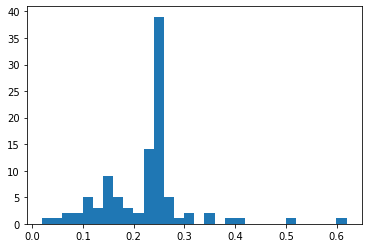

In [24]:
plt.hist(pred,bins=30) #without early stopping

In [23]:
np.max(y_test_normalized),np.min(y_test_normalized)

(0.9999810333556409, 2.845308524568324e-06)

(array([323., 337., 402., 345., 349., 391., 296., 278., 320., 262., 330.,
        305., 300., 293., 380., 306., 330., 365., 298., 339., 326., 279.,
        319., 336., 345., 381., 372., 322., 352., 419.]),
 array([2.84530852e-06, 3.33354516e-02, 6.66680578e-02, 1.00000664e-01,
        1.33333270e-01, 1.66665877e-01, 1.99998483e-01, 2.33331089e-01,
        2.66663695e-01, 2.99996302e-01, 3.33328908e-01, 3.66661514e-01,
        3.99994121e-01, 4.33326727e-01, 4.66659333e-01, 4.99991939e-01,
        5.33324546e-01, 5.66657152e-01, 5.99989758e-01, 6.33322364e-01,
        6.66654971e-01, 6.99987577e-01, 7.33320183e-01, 7.66652789e-01,
        7.99985396e-01, 8.33318002e-01, 8.66650608e-01, 8.99983215e-01,
        9.33315821e-01, 9.66648427e-01, 9.99981033e-01]),
 <BarContainer object of 30 artists>)

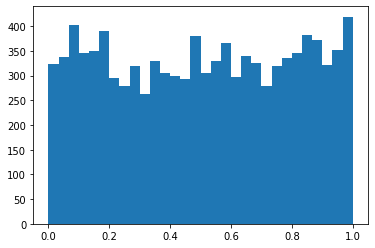

In [18]:
plt.hist(y_test_normalized[:,0],bins=30)

(array([359., 352., 354., 361., 398., 351., 323., 294., 311., 339., 288.,
        309., 297., 292., 317., 333., 324., 309., 328., 303., 333., 330.,
        309., 301., 366., 359., 384., 340., 365., 371.]),
 array([1.39655893e-04, 3.34660893e-02, 6.67925227e-02, 1.00118956e-01,
        1.33445390e-01, 1.66771823e-01, 2.00098256e-01, 2.33424690e-01,
        2.66751123e-01, 3.00077557e-01, 3.33403990e-01, 3.66730423e-01,
        4.00056857e-01, 4.33383290e-01, 4.66709724e-01, 5.00036157e-01,
        5.33362590e-01, 5.66689024e-01, 6.00015457e-01, 6.33341891e-01,
        6.66668324e-01, 6.99994757e-01, 7.33321191e-01, 7.66647624e-01,
        7.99974058e-01, 8.33300491e-01, 8.66626924e-01, 8.99953358e-01,
        9.33279791e-01, 9.66606225e-01, 9.99932658e-01]),
 <BarContainer object of 30 artists>)

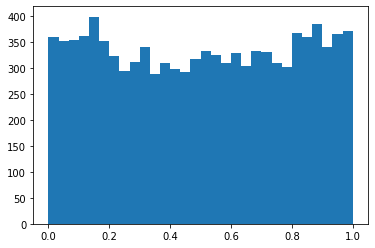

In [19]:
plt.hist(y_test_normalized[:,1],bins=30)

(array([1.15680007, 0.        , 2.8920008 , 0.        , 1.15680007,
        1.7352001 , 4.62720028, 1.15680007, 1.7352001 , 0.57840003,
        0.        , 1.7352001 , 0.        , 1.7352001 , 5.20560031,
        1.7352001 , 7.51920045, 3.47040021, 5.78400034, 6.94080041,
        2.89200017, 0.57840003, 0.        , 2.31360014, 1.7352001 ,
        0.        , 0.57840003, 0.        , 0.        , 0.57840103]),
 array([0.01559276, 0.03288183, 0.0501709 , 0.06745997, 0.08474904,
        0.10203812, 0.11932719, 0.13661626, 0.15390533, 0.1711944 ,
        0.18848348, 0.20577255, 0.22306162, 0.2403507 , 0.25763977,
        0.27492884, 0.2922179 , 0.30950698, 0.32679605, 0.34408513,
        0.3613742 , 0.37866327, 0.39595234, 0.41324142, 0.4305305 ,
        0.44781956, 0.46510863, 0.4823977 , 0.49968678, 0.5169759 ,
        0.5342649 ], dtype=float32),
 <BarContainer object of 30 artists>)

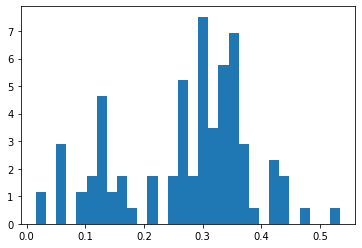

In [13]:
plt.hist(pred,bins=30,density=True) #without centroid method

(array([ 0.51002406,  0.        ,  0.        ,  0.51002406,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.51002329,
         0.51002484,  9.18044706, 29.5813506 ,  9.18044706,  1.02004967]),
 array([0.40445426, 0.42406118, 0.44366807, 0.46327496, 0.48288187,
        0.5024888 , 0.5220957 , 0.54170257, 0.56130946, 0.5809164 ,
        0.6005233 , 0.6201302 , 0.6397371 , 0.659344  , 0.6789509 ,
        0.6985578 , 0.7181647 , 0.73777163, 0.7573785 , 0.7769854 ,
        0.79659235, 0.81619924, 0.83580613, 0.855413  , 0.8750199 ,
        0.89462686, 0.91423374, 0.93384063, 0.9534476 , 0.97305447,
        0.99266136], dtype=float32),
 <BarContainer object of 30 artists>)

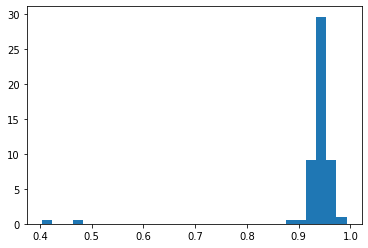

In [27]:
plt.hist(pred,bins=30,density=True) #predict with centroid method

(array([0.37401243, 0.        , 0.        , 0.        , 0.        ,
        0.37401223, 0.        , 0.37401223, 0.37401264, 0.37401223,
        0.37401223, 0.74802528, 0.74802445, 0.74802445, 0.74802445,
        0.37401223, 0.74802445, 1.4960489 , 3.74013059, 5.23617116,
        4.11413448, 4.86215893, 1.87006113, 1.12203668, 1.12203668,
        0.74802612, 0.74802445, 2.24407335, 1.12203668, 2.61808558]),
 array([0.09839867, 0.12513575, 0.15187284, 0.17860994, 0.20534702,
        0.2320841 , 0.2588212 , 0.28555828, 0.31229538, 0.33903244,
        0.36576954, 0.39250663, 0.4192437 , 0.4459808 , 0.47271788,
        0.49945498, 0.52619207, 0.55292916, 0.57966626, 0.6064033 ,
        0.6331404 , 0.6598775 , 0.6866146 , 0.71335167, 0.74008876,
        0.76682585, 0.7935629 , 0.8203    , 0.8470371 , 0.8737742 ,
        0.90051126], dtype=float32),
 <BarContainer object of 30 artists>)

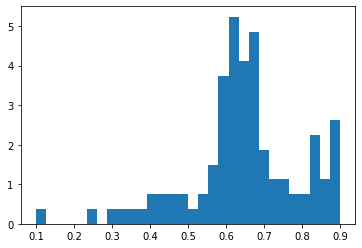

In [34]:
plt.hist(pred[:,0],bins=30,density=1)

In [24]:
from keras import constraints
from keras import initializers
from keras import regularizers

class CentroidDense(tf.keras.layers.Layer):
    #the only difference with dense is that it has an extra step of flattening the input
    def __init__(self,units,activation=None,use_bias=True,
                 kernel_initializer=None,
                 kernel_regularizer=None,
                 bias_initializer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(CentroidDense, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

    def build(self, input_shape): 
        
        #not flattened input, (f,t,#filters)
        self.freq,self.time,self.width = input_shape #(f,t,#filters)
        
        self.kernel = self.add_weight(
                        'kernel',
                        shape=[self.width*self.time, self.units],
                        initializer=self.kernel_initializer,
                        regularizer=self.kernel_regularizer,
                        constraint=self.kernel_constraint,
                        dtype=self.dtype,
                        trainable=True)
        #initialize trainable weights
        if self.use_bias:
            self.bias = self.add_weight(
              'bias',
              shape=[self.units,],
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              dtype=self.dtype,
              trainable=True)
        else:
            self.bias = None
    
        super(CentroidDense, self).build(input_shape)

    def call(self,inputs,vector,i): #the vector always match first dimension of input
        """
        i: along which channel of the inputs should vector be multiplied 
        """
        vector = K.constant(vector)
        assert inputs.shape[i]==vector.shape[i]
        
        #normalize input into a pdf distribution
        inputs = inputs/tf.linalg.norm(inputs,ord=1)
        
        #multiply input with vector along frequency dimension/ or some defined dimension
        if i == 0:
            inputs = inputs*tf.broadcast_to(vector[:,None,None],inputs.shape)
        elif i == 1:
            inputs = inputs*tf.broadcast_to(vector[None,:,None],inputs.shape)
        elif i == 2:
            inputs = inputs*tf.broadcast_to(vector[None,None,:],inputs.shape)
            
        print(inputs.shape)
        #sum over frequency dimension
        inputs = tf.reduce_sum(inputs,axis=i)
        #flatten input
        inputs = tf.reshape(inputs,tf.reduce_prod(inputs.shape))
        print("afterflatten",inputs.shape,self.kernel.shape)
        #multiply with kernel
        rank = inputs.shape.rank
        
        outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
        print(outputs.shape,inputs.shape,self.bias.shape)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs[None,:], self.bias)
        return outputs

    def compute_output_shape(self, input_shape):

        return input_shape[:-1]


In [9]:
kernel = np.random.rand(8,1,1,12) #kernel size1, kernel size2, #channels from last layer, #filters 
vec = np.random.rand(192,)
print(kernel.shape,vec.shape)
tf.tensordot(kernel,vec,axes=0).shape


(8, 1, 1, 12) (192,)


TensorShape([8, 1, 1, 12, 192])

In [10]:
kernel.shape
kernel2=tf.reduce_sum(kernel,axis=-1)
kernel2.shape

TensorShape([8, 1, 1])

In [11]:
vec_2 = tf.broadcast_to(tf.constant(vec[:,None]),[192,64])
vec_2
#vec_3.reshape((vec_3.shape[0]))

<tf.Tensor: shape=(192, 64), dtype=float64, numpy=
array([[0.54155055, 0.54155055, 0.54155055, ..., 0.54155055, 0.54155055,
        0.54155055],
       [0.0797875 , 0.0797875 , 0.0797875 , ..., 0.0797875 , 0.0797875 ,
        0.0797875 ],
       [0.52692608, 0.52692608, 0.52692608, ..., 0.52692608, 0.52692608,
        0.52692608],
       ...,
       [0.21906377, 0.21906377, 0.21906377, ..., 0.21906377, 0.21906377,
        0.21906377],
       [0.45887931, 0.45887931, 0.45887931, ..., 0.45887931, 0.45887931,
        0.45887931],
       [0.36512424, 0.36512424, 0.36512424, ..., 0.36512424, 0.36512424,
        0.36512424]])>

In [12]:
inputs = np.random.rand(192,2,64)#bs,f, t, filters
vector = np.random.rand(192,)
print(inputs.shape,vector.shape)

(192, 2, 64) (192,)


In [25]:
x = CentroidDense(units=64,use_bias=True,name="freqcentroid")(inputs,vector)

(192, 2, 64)
afterflatten (128,) (128, 64)
(64,) (128,) (64,)


In [81]:
x.shape

TensorShape([64])